#Guided Grad CAM

### Essential libraries

In [ ]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

### VGG16 model and preprocessing

In [ ]:
# Load the pre-trained VGG16 model
model = models.vgg16(pretrained=True)
model.eval()

# Preprocessing function
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


<ipython-input-2-aeed3a912ae5>:50: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  cam = Image.fromarray(cam).resize((224, 224), Image.ANTIALIAS)  # Ensure size is (224, 224)


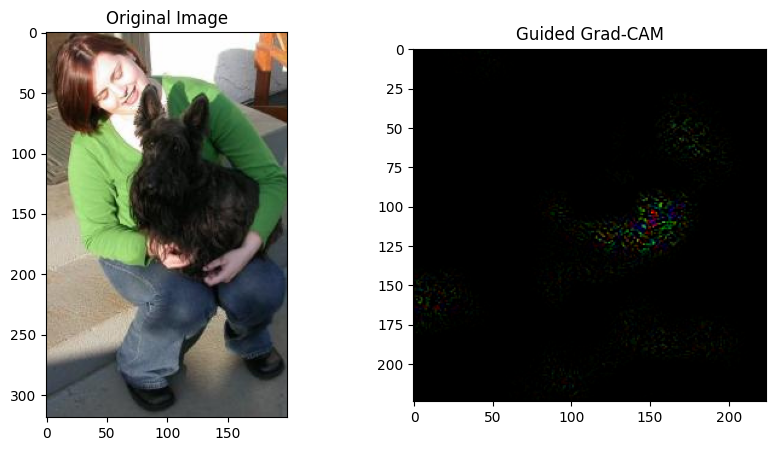

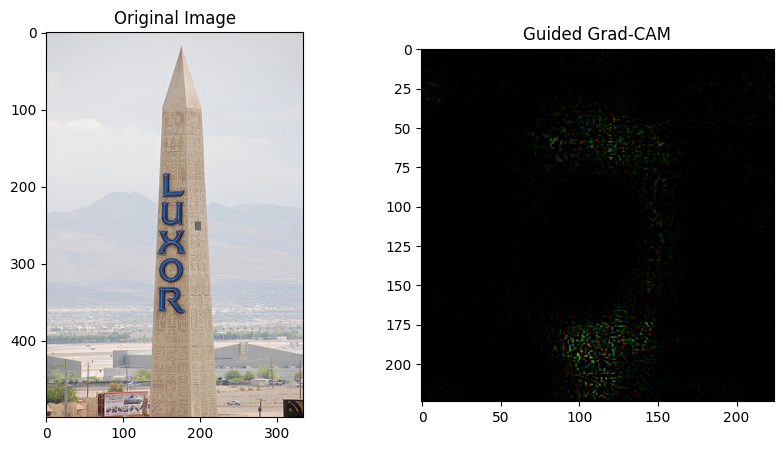

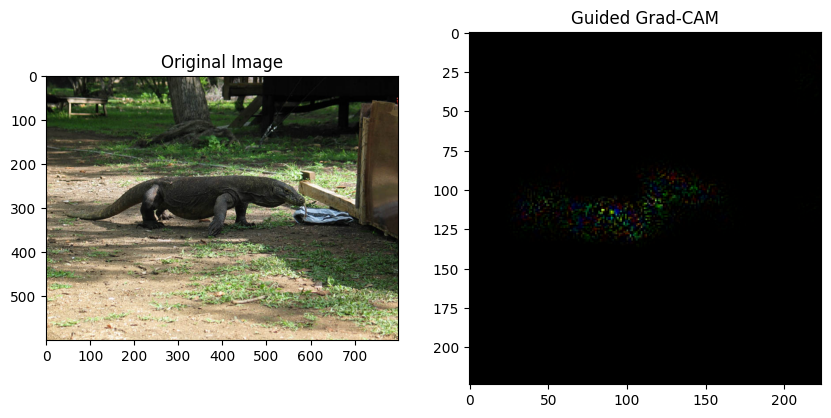

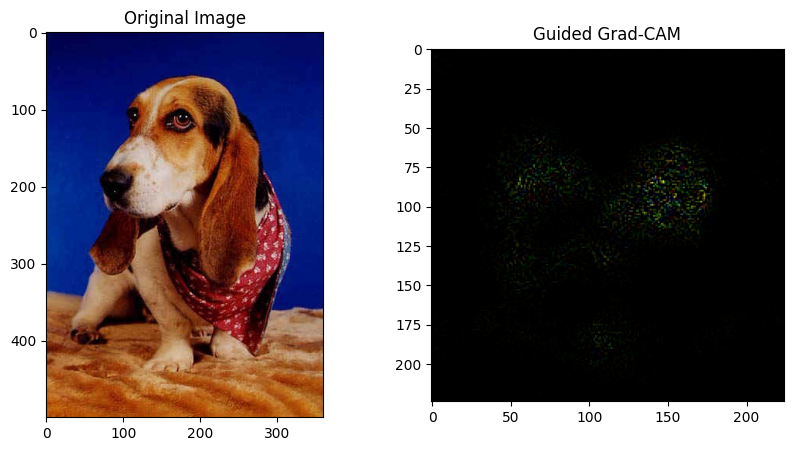

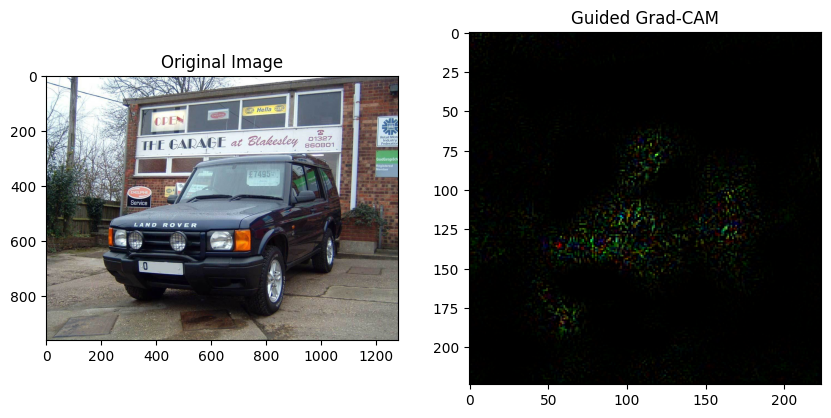

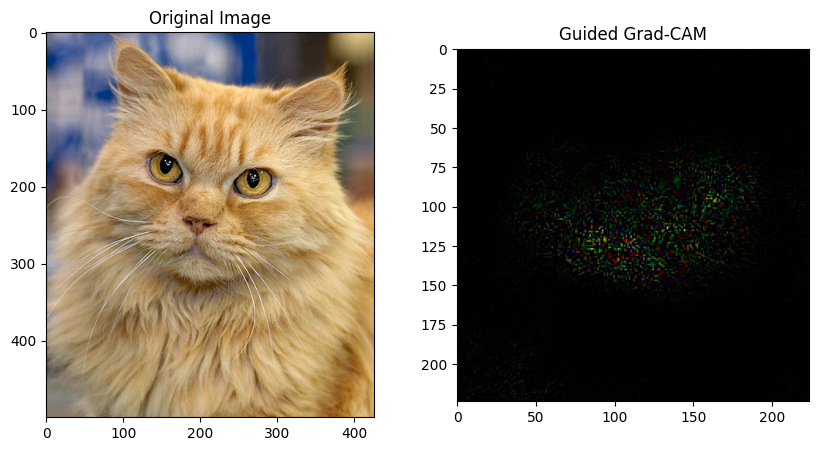

In [ ]:
# Function to apply Grad-CAM
def grad_cam(model, image, target_layer, target_class):
    model.eval()
    features = []
    gradients = []

    def forward_hook(module, input, output):
        features.append(output)

    def backward_hook(module, grad_in, grad_out):
        gradients.append(grad_out[0])

    # Register hooks to the target layer
    handle_forward = target_layer.register_forward_hook(forward_hook)
    handle_backward = target_layer.register_backward_hook(backward_hook)

    # Image preprocessing and forward pass
    tensor = preprocess(image).unsqueeze(0)
    tensor.requires_grad = True
    output = model(tensor)

    target = output[0][target_class]

    model.zero_grad()
    target.backward()

    # Remove hooks
    handle_forward.remove()
    handle_backward.remove()

    # Get the gradients and feature map
    gradients = gradients[0].cpu().data.numpy()[0]
    feature_map = features[0].cpu().data.numpy()[0]

    # Pool the gradients across the width and height dimensions
    pooled_gradients = np.mean(gradients, axis=(1, 2))

    # Weight the feature map with the pooled gradients
    for i in range(pooled_gradients.shape[0]):
        feature_map[i, ...] *= pooled_gradients[i]

    # Generate the CAM
    cam = np.mean(feature_map, axis=0)
    cam = np.maximum(cam, 0)  # Apply ReLU
    cam = cam - np.min(cam)
    cam = cam / np.max(cam)
    cam = np.uint8(255 * cam)

    # Resize the CAM to the size of the input image
    cam = Image.fromarray(cam).resize((224, 224), Image.ANTIALIAS)  # Ensure size is (224, 224)
    cam = np.array(cam)

    return cam

# Function for Guided Backpropagation
def guided_backprop(model, image, target_class):
    image = preprocess(image).unsqueeze(0)
    image.requires_grad = True

    model.zero_grad()
    output = model(image)
    target = output[0][target_class]
    target.backward()

    grad = image.grad.data[0].cpu().numpy()
    grad = np.maximum(grad, 0)  # Apply ReLU to gradients

    return grad

# Function to combine Grad-CAM and Guided Backpropagation
def guided_grad_cam(model, image, target_layer, target_class):
    cam = grad_cam(model, image, target_layer, target_class)
    guided_grad = guided_backprop(model, image, target_class)

    # Ensure the dimensions match
    cam = cam / 255.0
    cam = np.expand_dims(cam, axis=0)  # Add a channel dimension
    guided_grad = guided_grad * cam

    return guided_grad

# Function to display the results
def display_results(image_path, target_class, target_layer):
    image = Image.open(image_path).convert('RGB')
    result = guided_grad_cam(model, image, target_layer, target_class)

    # Normalize the result for better visualization
    result -= result.min()
    result /= result.max()

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title('Original Image')

    plt.subplot(1, 2, 2)
    plt.imshow(np.transpose(result, (1, 2, 0)))
    plt.title('Guided Grad-CAM')
    plt.show()

# Example usage for multiple images
image_paths = [
    '/content/n02097298_Scotch_terrier.JPEG',
    '/content/n03837869_obelisk.JPEG',
    '/content/n01695060_Komodo_dragon.JPEG',
    '/content/n02088238_basset.JPEG',
    '/content/n03594945_jeep.JPEG',
    '/content/n02123394_Persian_cat.JPEG'
]

target_classes = [
    109,  # Scotch terrier
    538,  # Obelisk
    473,  # Komodo dragon
    161,  # Basset
    609,  # Jeep
    283   # Persian cat
]

# Select the layer you want to visualize
target_layer = model.features[29]

# Generate and display results for each image
for image_path, target_class in zip(image_paths, target_classes):
    display_results(image_path, target_class, target_layer)
